In [1]:
#imports
import pandas as pd
from cancer_analysis_functions import pre_process,kalman_meier_fitter_analysis,log_rank_survival_analysis,plot_feature_importance,plot_feature_importance,demographic_analysis
import numpy as np
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
file_path = r"C:\Users\aviga\pythonProject\cancer_homework\clinical.tsv"  # Update with your file path
df = pd.read_csv(file_path, sep="\t")
# Perform pre-processing
df = pre_process(df)
df.head()

,case_id,age_at_index,days_to_birth,days_to_death,ethnicity,gender,race,vital_status,year_of_birth,year_of_death,...,primary_diagnosis,prior_malignancy,prior_treatment,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_stage,year_of_diagnosis,treatment_or_therapy,treatment_type
0,7570761b-c333-40df-ac8c-9b7f94c58ef9,73,-27020,1089.0,not hispanic or latino,female,white,0,1935,<NA>,...,"Adenocarcinoma, NOS",yes,No,Ascending colon,Not Reported,Ascending colon,stage iia,2008.0,no,"Pharmaceutical Therapy, NOS"
1,7570761b-c333-40df-ac8c-9b7f94c58ef9,73,-27020,1089.0,not hispanic or latino,female,white,0,1935,<NA>,...,"Adenocarcinoma, NOS",yes,No,Ascending colon,Not Reported,Ascending colon,stage iia,2008.0,no,"Radiation Therapy, NOS"
2,14c13b05-abfe-472e-83a9-b28f60e58ad8,69,-25243,1935.0,not hispanic or latino,male,white,0,1939,<NA>,...,"Adenocarcinoma, NOS",yes,No,"Colon, NOS",Not Reported,"Colon, NOS",stage iiib,2008.0,yes,"Radiation Therapy, NOS"
3,14c13b05-abfe-472e-83a9-b28f60e58ad8,69,-25243,1935.0,not hispanic or latino,male,white,0,1939,<NA>,...,"Adenocarcinoma, NOS",yes,No,"Colon, NOS",Not Reported,"Colon, NOS",stage iiib,2008.0,yes,"Pharmaceutical Therapy, NOS"
4,a5e14add-1552-4606-9ffe-3a03bcf76640,42,-15494,385.0,not hispanic or latino,female,black or african american,0,1971,<NA>,...,Mucinous adenocarcinoma,no,No,Descending colon,No,Descending colon,stage iia,2013.0,no,"Pharmaceutical Therapy, NOS"


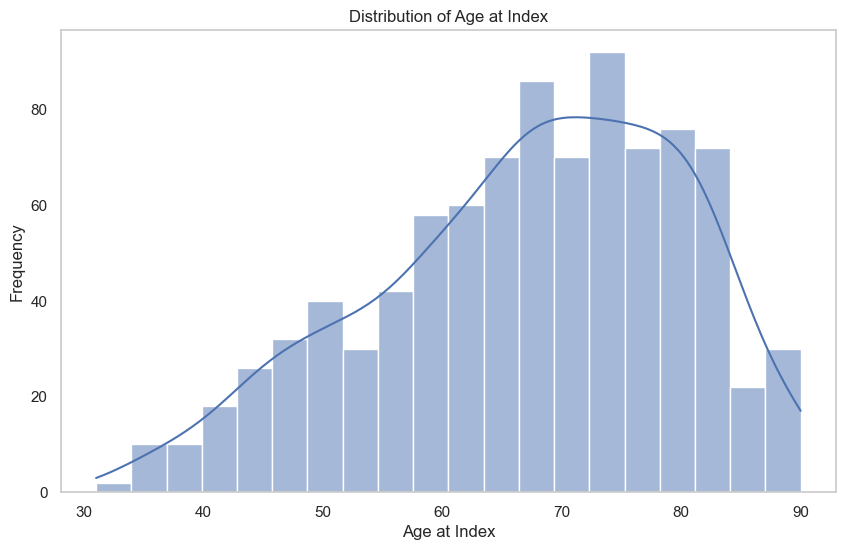

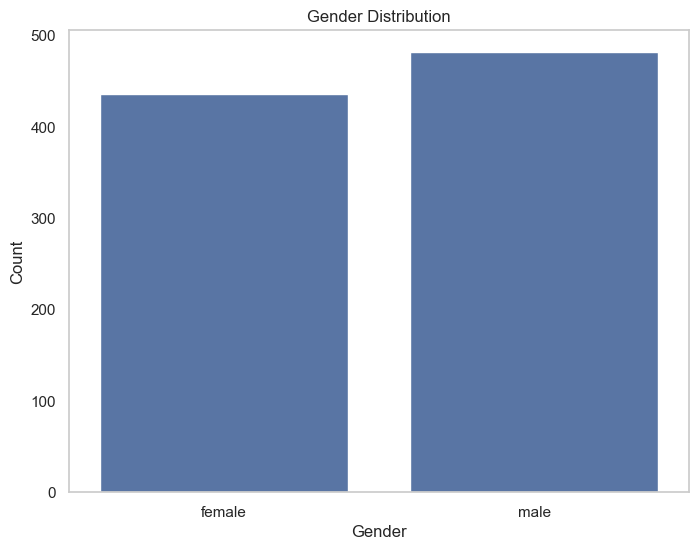

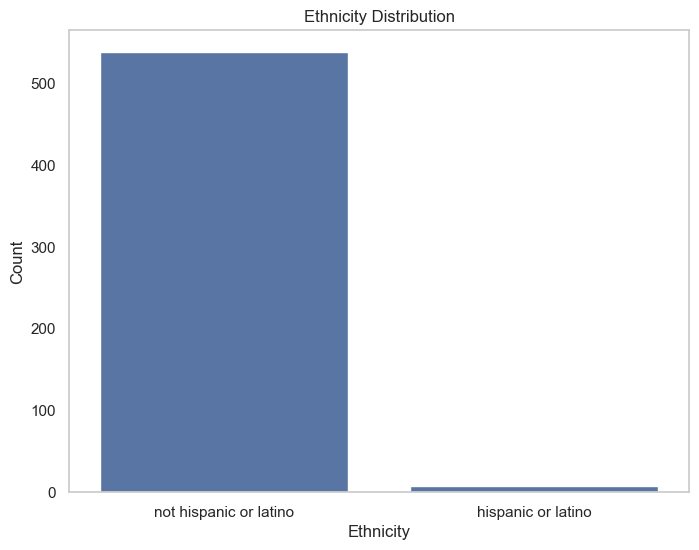

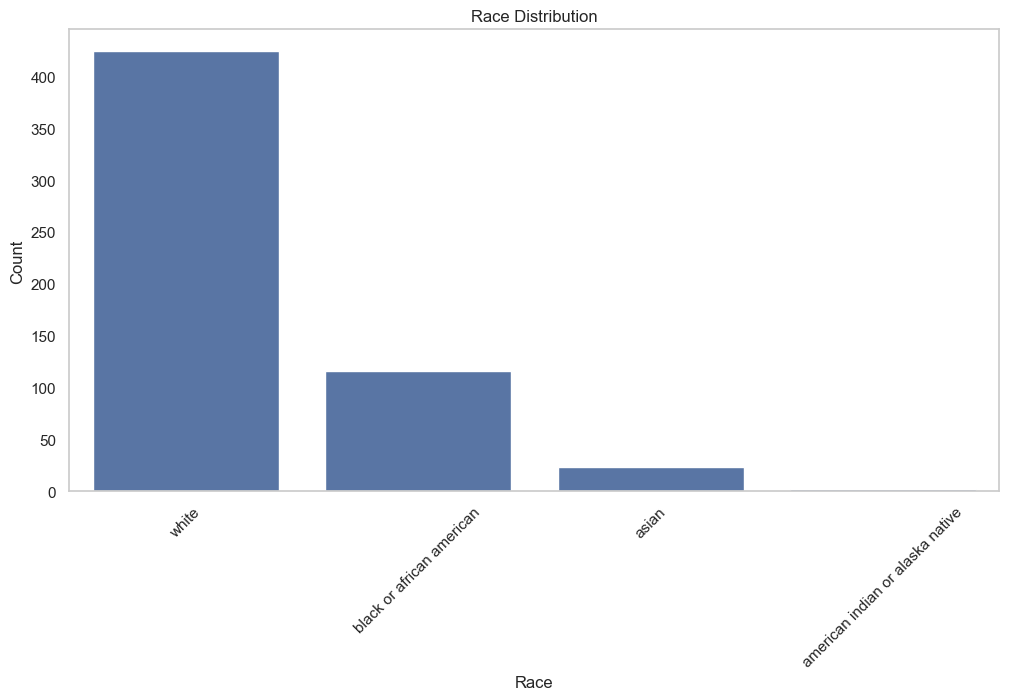

In [3]:
demographic_analysis(df)

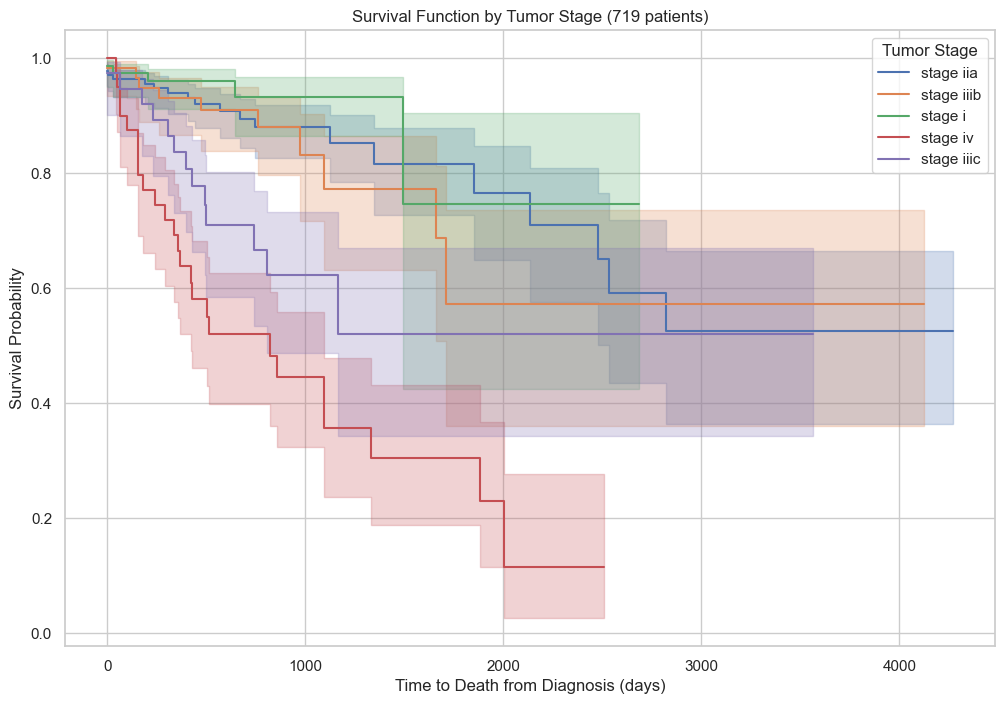

In [4]:
survival_tumor_stage_df = kalman_meier_fitter_analysis(df)


Pairwise Log-rank test results:
                       test_statistic             p   -log2(p)
stage i    stage iia         2.043099  1.528979e-01   2.709360
           stage iiib        3.396165  6.534818e-02   3.935709
           stage iiic       24.025383  9.507402e-07  20.004445
           stage iv         64.005301  1.240849e-15  49.517594
stage iia  stage iiib        0.385880  5.344732e-01   0.903811
           stage iiic       15.976901  6.412010e-05  13.928864
           stage iv         81.384872  1.857745e-19  62.223081
stage iiib stage iiic        8.698775  3.184240e-03   8.294835
           stage iv         37.385707  9.692987e-10  29.942340
stage iiic stage iv          8.399823  3.752575e-03   8.057903


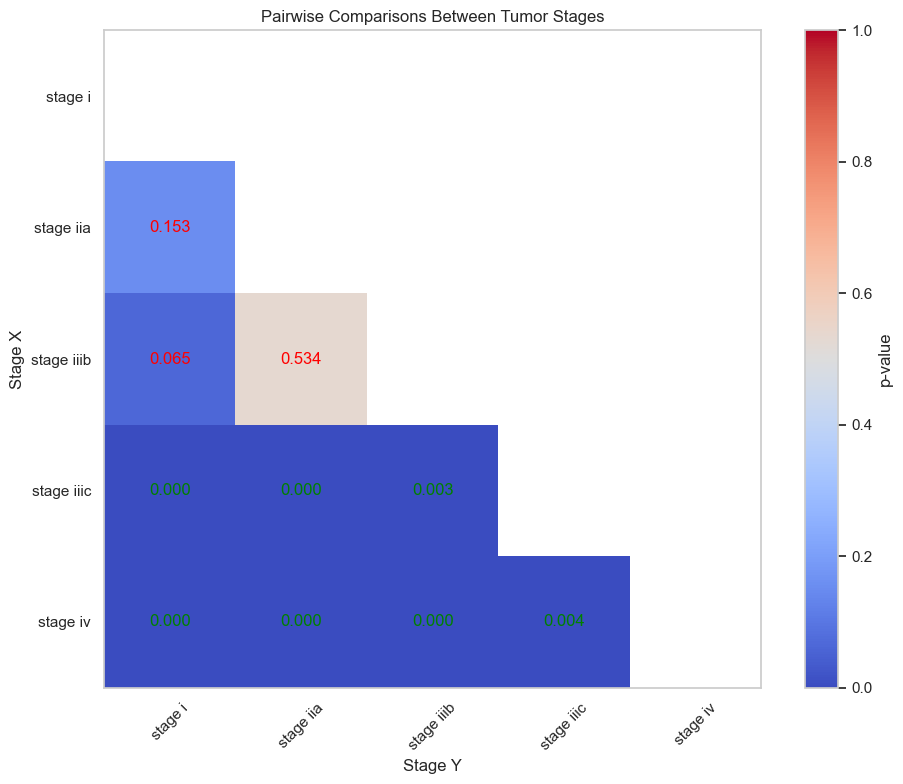

In [5]:
log_rank_survival_analysis(survival_tumor_stage_df)

In [6]:
features_columns=['gender','ajcc_pathologic_m','ajcc_pathologic_n','ajcc_pathologic_stage','ajcc_pathologic_t','morphology','primary_diagnosis','site_of_resection_or_biopsy']
X=pd.DataFrame()
# df=df.sample(frac=0.1, random_state=42)
#make dummy variables
for column in features_columns:
    dummy_variables = pd.get_dummies(df[column], prefix='encoded')
    X = pd.concat([X, dummy_variables], axis=1)
# Split the data into features and target variables
duration='days_to_death'
y = Surv.from_dataframe("vital_status", duration, df)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and fit the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, max_features="sqrt", n_jobs=-1, random_state=42)
# Fit the model
rsf.fit(X_train, y_train)
# Predict survival times on the test set
predicted_survival_times = rsf.predict(X_test)
# Evaluate the model using concordance index
ci = concordance_index_censored(y_test['vital_status'], y_test[duration], predicted_survival_times)
# Calculate permutation importance
perm_importance = permutation_importance(rsf, X_test, y_test, n_repeats=7, random_state=42, n_jobs=-1)

# Extract feature importances
importances = perm_importance.importances_mean
indices = np.argsort(importances)[::-1]
features = X.columns

plot_feature_importance(importances,indices,features,ci[0])

In [ ]:
# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Set a threshold for feature selection
threshold = 0.001

# Select important features
important_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

# Filter the data to include only important features
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Retrain the model with reduced features
rsf_reduced = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, max_features="sqrt", n_jobs=-1, random_state=42)

# Fit the reduced model
rsf_reduced.fit(X_train_reduced, y_train)

# Predict survival times on the test set with reduced features
predicted_survival_times_reduced = rsf_reduced.predict(X_test_reduced)

# Evaluate the model using concordance index
ci_reduced = concordance_index_censored(y_test['vital_status'], y_test[duration], predicted_survival_times_reduced)

# Calculate permutation importance for the reduced model
perm_importance_reduced = permutation_importance(rsf_reduced, X_test_reduced, y_test, n_repeats=7, random_state=42, n_jobs=-1)
importances_reduced = perm_importance_reduced.importances_mean
indices_reduced = np.argsort(importances_reduced)[::-1]
features_reduces = X[important_features].columns
plot_feature_importance(importances_reduced, indices_reduced, features_reduces,ci_reduced[0])    